# Prova estrazione Growth factor da CLASS

In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from classy import Class
from scipy import interpolate

# Primo tentativo: dal notebook

In [3]:
w0vec = [-0.7, -1.0, -1.3]
wavec = [-0.2,0.0,0.2]
#w0vec = [-1.0]
#wavec = [0.0]
 
cosmo = {}
for w0 in w0vec:
    for wa in wavec:
        if w0==-1.0 and wa==0.0:
            M='LCDM'
        else:
            M = '('+str(w0)+','+str(wa)+')'
        cosmo[M] = Class()
        cosmo[M].set({'input_verbose':1,'background_verbose':1,'gauge' : 'Newtonian'})
        if M!='LCDM':
            cosmo[M].set({'Omega_Lambda':0.,'w0_fld':w0,'wa_fld':wa, 'N_ncdm': 1, 'm_ncdm': 0.06})
        cosmo[M].compute()

Reading input parameters
 -> matched budget equations by adjusting Omega_fld = 0.688625
Running CLASS version v3.2.1
Computing background
 -> non-cold dark matter species with i=1 has m_i = 6.000000e-02 eV (so m_i / omega_i =9.313858e+01 eV)
 -> ncdm species i=1 sampled with 11 (resp. 11) points for purpose of background (resp. perturbation) integration. In the relativistic limit it gives Delta N_eff = 1.0132
 -> age = 13.161857 Gyr
 -> conformal age = 13762.633515 Mpc
 -> N_eff = 4.0572 (summed over all species that are non-relativistic at early times) 
 -> radiation/matter equality at z = 2998.855831
    corresponding to conformal time = 120.107926 Mpc
Reading input parameters
 -> matched budget equations by adjusting Omega_fld = 0.688625
Running CLASS version v3.2.1
Computing background
 -> non-cold dark matter species with i=1 has m_i = 6.000000e-02 eV (so m_i / omega_i =9.313858e+01 eV)
 -> ncdm species i=1 sampled with 11 (resp. 11) points for purpose of background (resp. perturb

In [4]:
import scipy
import scipy.special
import scipy.integrate

def D_hypergeom(avec,csm):
    bg = csm.get_background()
    Om = csm.Omega0_m()
    if '(.)rho_lambda' in bg:
        Ol = bg['(.)rho_lambda'][-1]/bg['(.)rho_crit'][-1]
    else:
        Ol = bg['(.)rho_fld'][-1]/bg['(.)rho_crit'][-1]
        
    x = Ol/Om*avec**3
    D = avec*scipy.special.hyp2f1(1./3.,1,11./6.,-x)
    D_today = scipy.special.hyp2f1(1./3.,1,11./6.,-Ol/Om)
    return D/D_today

In [5]:

bg = cosmo['LCDM'].get_background()

z = bg['z']
a = 1./(z+1)

D_app = bg['gr.fac. D']     #D approssimato
D_ana = D_hypergeom(a,cosmo['LCDM'])    #D analitico


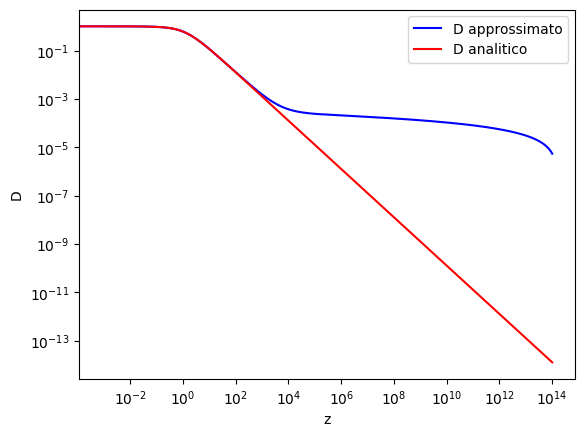

In [6]:
plt.loglog(z, D_app, color='blue', label='D approssimato')
plt.loglog(z, D_ana, color='red', label='D analitico')

plt.xlabel('z')
plt.ylabel('D')

plt.legend()
plt.draw()

# Secondo tentativo

In [7]:
from classy import Class

In [8]:
M = Class()
cosmo = {'omega_b': 0.02238280, 'omega_cdm': 0.1201075, 'h': 0.67810, 'ln10^{10}A_s': 3.04478383, 'n_s': 0.9660499, 'N_ncdm': 1, 'm_ncdm': 0.06}
M.set(cosmo)
M.set({'output': 'mPk', 'P_k_max_h/Mpc': 10, 'z_max_pk': 1})
M.compute()

In [9]:
bg = M.get_background()

z = bg['z']
a = 1./(z+1)

D_num = bg['gr.fac. D']     #D numerico
D_ana = D_hypergeom(a,M)    #D analitico

print(z[0])
print(z[37023])
print(z[-1])

99999999999999.12
10.005912117879722
0.0


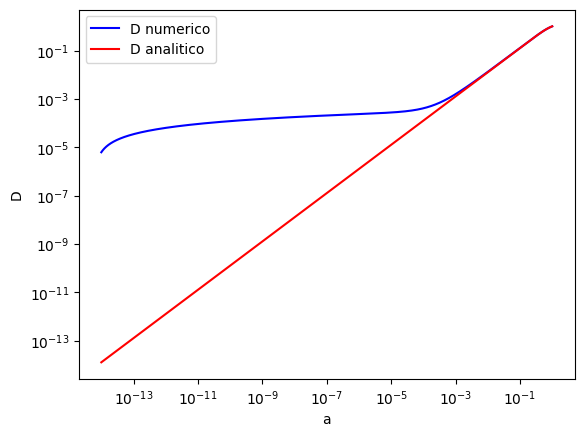

In [10]:
plt.loglog(a, D_num, color='blue', label='D numerico')
plt.loglog(a, D_ana, color='red', label='D analitico')

plt.xlabel('a')
plt.ylabel('D')

plt.legend()
plt.draw()

# Terzo tentativo: growth rate

$$ f = \dfrac{d \ln D(a)}{d \ln a} $$

In [11]:
f_ind = []
f_dep = []
R = np.empty(0)

# fisso la scala
k = 0.001

# considero il redshift (r) tra 0 e 2, altriemnti non calcola D dipendente dalla scala
for i in range(2000, 0, -1) :
    r = i/1000.
    R = np.append(R,r)
    f_ind.append(M.scale_independent_growth_factor_f(r))
    f_dep.append(M.scale_dependent_growth_factor_f(k, r))

A = 1./(R+1)


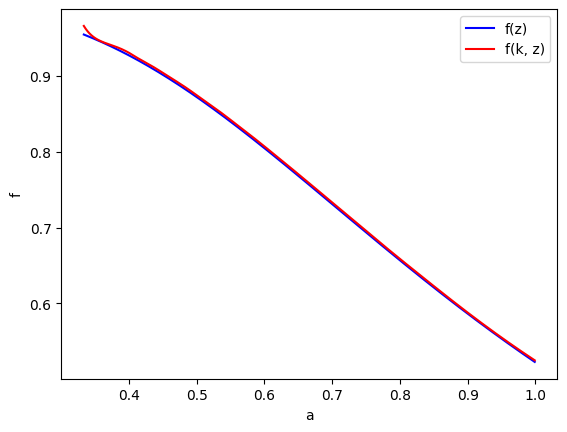

In [12]:
plt.plot(A, f_ind, color='blue', label='f(z)')
plt.plot(A, f_dep, color='red', label='f(k, z)')

plt.xlabel('a')
plt.ylabel('f')

plt.legend()
plt.show()

**Paragono i growth factors del secondo e del terzo tentativo**

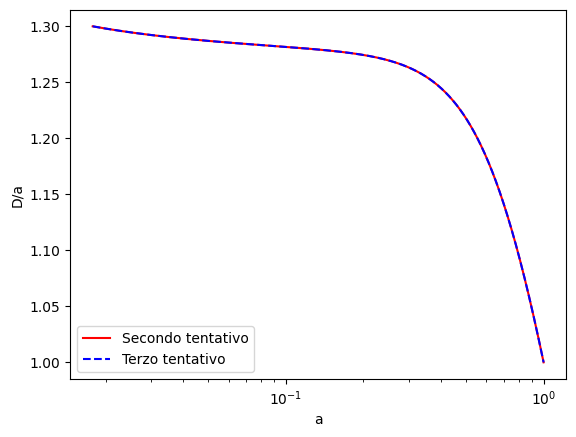

In [13]:
# oltre a confrontare i due precdenti risultati ho provato a riottenere la figura 8.15 del Dodelson, pag 221, ma il risultato non è corretto
D2 = D_num
D3 = []

z = bg['z']
a = 1./(z+1)

for r in z :
    D3.append(M.scale_independent_growth_factor(r))
s = 5000
plt.semilogx(a[-s:], D2[-s:]/a[-s:], color='red', label='Secondo tentativo')
plt.semilogx(a[-s:], D3[-s:]/a[-s:], ls='--', color='blue', label='Terzo tentativo')

plt.xlabel('a')
plt.ylabel('D/a')

plt.legend()
plt.show()

# Quarto tentativo: rapporto dei Power spectra

$$ P(k,z) = \mathcal{P}(k) T^2(k)D^2(k,z) = \mathcal{P}(k) T^2(k)\bar{D}^2(z)\mu^2(k,z) $$
$$ \mathcal{D}(k,z) = \sqrt{\dfrac{P(k,z)}{P(k,0)}} = \dfrac{D(k,z)}{D(k,0)} = \dfrac{\bar{D}(z)\mu(k,z)}{\bar{D}(0)\mu(k,0)} $$

Voglio confrontare il risultato con il growth factor scale independent estratto da CLASS $\bar{D}(z)$

In [14]:
# creao una cosmologia
LambdaCDM = Class()
# setto i parametri del modello
LambdaCDM.set({
    'omega_b': 0.02238280, 
    'omega_cdm': 0.1201075, 
    'h': 0.67810, 
    'A_s': 2.100549e-09, 
    'n_s': 0.9660499, 
    'tau_reio': 0.05430842, 
    'z_max_pk': 10,
    'N_ncdm': 1,
    'm_ncdm': 0.06
    })
LambdaCDM.set({'output':'tCl,pCl,lCl,mPk',
               'lensing':'yes',
               'P_k_max_1/Mpc':3.0
               })
# eseguo CLASS
LambdaCDM.compute()

In [15]:
# definisco il range di scale k = [10^-4; 3] e di redshift z = [0; 10]
n = 300
kk = np.logspace(-4, np.log10(3), n)    # k in h/Mpc
zz = np.arange(10, 0, -10/n)            # 2977 punti di reshift
aa = 1./(zz+1)                          # converto il redshift in fattore di scala

#Pkz = [[0 for i in range(n)] for j in range(n)]
Pkz = np.zeros([n,n])
h = LambdaCDM.h()       # get reduced Hubble for conversions to 1/Mpc

# calcolo il Power spectrum per tutti i valori di k e a
for k in range(n) :
    for a in range(n) :
        Pkz[k,a] = LambdaCDM.pk(kk[k], aa[a])


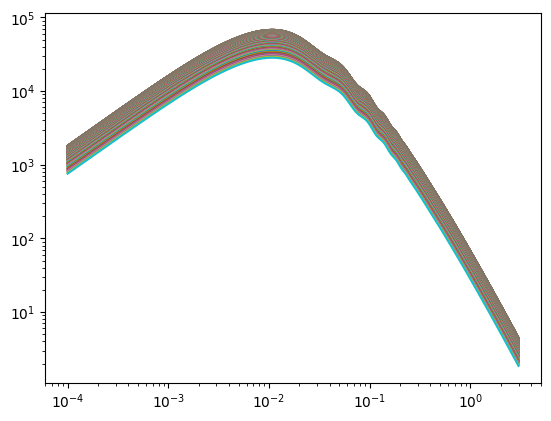

In [16]:
plt.loglog(kk, Pkz)
plt.show()

In [17]:
# estraggo il growth factor normalizato dal rapporto Pkz(k,0)/Pkz(k,z)
d = [[0 for i in range(n)] for i in range(n)]

for k in range(n) :
    for a in range(n) :
        d[k][a] = np.sqrt(Pkz[k][-1]/Pkz[k][a])

Dkz = np.array(d)

z0 = bg['z']
N = len(z0)
z = z0[N-n:]

a = 1./(z+1)
Dz = bg['gr.fac. D'][N-n:]


In [18]:
print(len(a))
print(len(aa))

300
300


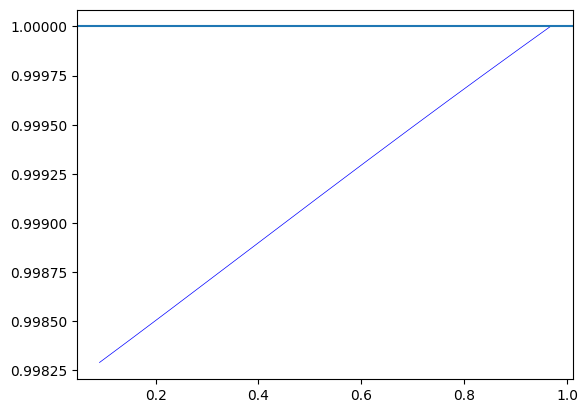

In [19]:
plt.plot(aa, Dkz[0,:]/Dkz[n-1,:], color='blue', label='D(' + str(kk[n-1]) + ',a)', linewidth='0.5')
plt.axhline(y=1)
plt.show()

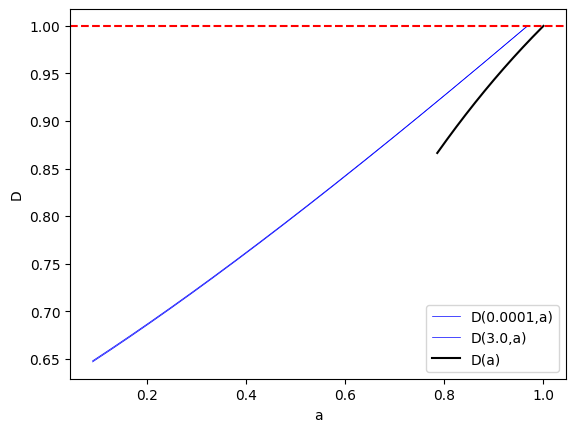

In [20]:
# plotto D(k,a) con variabile a e parametro k, plotto anche D(a)

plt.plot(aa, Dkz[0,:], color='blue', label='D(' + str(kk[0]) + ',a)', linewidth='0.5')
plt.plot(aa, Dkz[n-1,:], color='blue', label='D(' + str(kk[n-1]) + ',a)', linewidth='0.5')
plt.plot(a, Dz, color='black', label='D(a)')
plt.axhline(y=1, color='red', linestyle='--')

plt.xlabel('a')
plt.ylabel('D')

plt.legend()
plt.show()

In [21]:
# estraggo il growth factor normalizato dal rapporto Pkz(k,a)/Pkz(k,1) e lo confronto con quello scale independent

d = [[0 for i in range(n)] for i in range(n)]

for k in range(n) :
    for a in range(n) :
        d[k][a] = np.sqrt(Pkz[k][a]/Pkz[k][-1])

Dkz = np.array(d)

#np.save('D(k,z)', Dkz)
#np.savetxt('growth', Dkz)

z = bg['z'][N-n:]
a = 1./(z+1)

Dz = bg['gr.fac. D'][N-n:]

#np.save('D(z)', Dz)


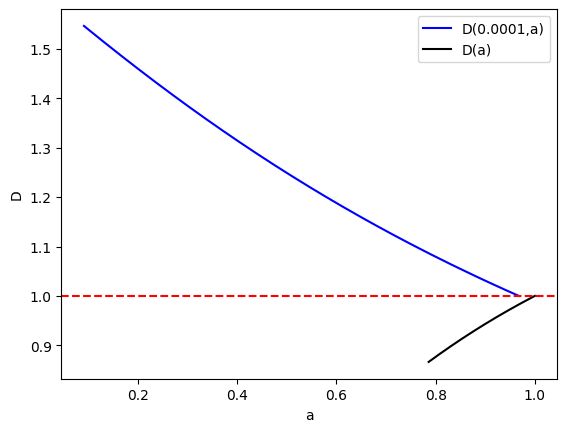

In [22]:
# plotto D(k,a) con variabile a e parametro k, plotto anche D(a)

plt.plot(aa, Dkz[0,:], color='blue', label='D(' + str(kk[0]) + ',a)') #, linewidth='0.5')
# plt.plot(aa, Dkz[2976,:], color='blue', label='D(' + str(kk[2976]) + ',a)', linewidth='0.5')
plt.plot(a, Dz, color='black', label='D(a)')
plt.axhline(y=1, color='red', linestyle='--')

plt.xlabel('a')
plt.ylabel('D')

plt.legend()
plt.show()

È come se P(k,1) crescesse più velocemente di P(k,a)

Provo a definire il rapporto tra $ \mathcal{D}(k,a) $ e $ \dfrac{\bar{D}(a)}{\bar{D}(1)} $, ottendnedo così $ \dfrac{\mu(k,a)}{\mu(k,1)} $

In [23]:
# calcolo mu

mu = d = [[0 for i in range(n)] for i in range(n)]

for k in range(n) :
    for a in range(n) :
        mu[k][a] = Dkz[k,a]/(Dz[a]/Dz[-1])

Mu = np.array(mu)


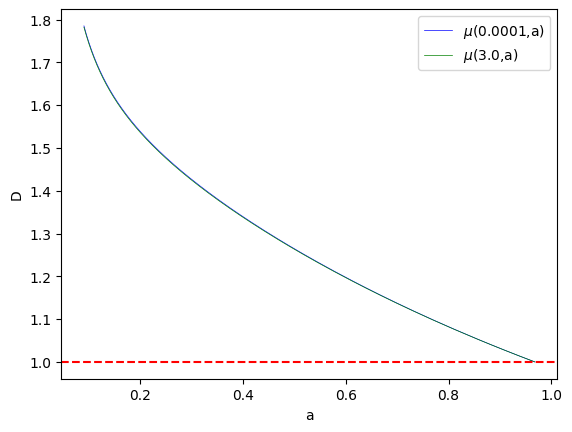

In [24]:
# plotto mu(a)

plt.plot(aa[:2000], Mu[0,:2000], color='blue', label='$\mu$(' + str(kk[0]) + ',a)', linewidth='0.5')
plt.plot(aa[:2000], Mu[-1,:2000], color='green', label='$\mu$(' + str(kk[-1]) + ',a)', linewidth='0.5')
plt.axhline(y=1, color='red', linestyle='--')

plt.xlabel('a')
plt.ylabel('D')

plt.legend()
plt.show()


In [25]:
# normalizzo anche il growth factor scale independent e provo a confrontare i due

z = bg['z'][N-n:]
a = 1./(z+1)

dz = bg['gr.fac. D'][N-n:]
Dz = [0 for i in range(n)]

for i in range(n) :
    Dz[i] = dz[i]/Pkz[i][-1]

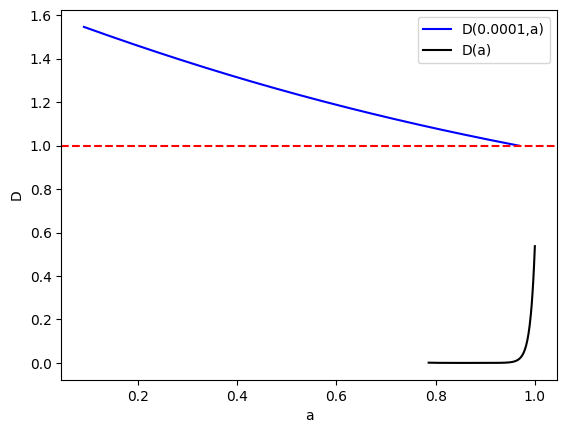

In [26]:
# plotto D(k,a) con variabile a e parametro k, plotto anche D(a) rinormalizzato

plt.plot(aa, Dkz[0,:], color='blue', label='D(' + str(kk[0]) + ',a)') #, linewidth='0.5')
# plt.plot(aa, Dkz[2976,:], color='blue', label='D(' + str(kk[2976]) + ',a)', linewidth='0.5')
plt.plot(a, Dz, color='black', label='D(a)')
plt.axhline(y=1, color='red', linestyle='--')

plt.xlabel('a')
plt.ylabel('D')

plt.legend()
plt.show()


# Provo una correzione a D

In [27]:
da = np.load('D(a)_m-neu=0.06.npy')
dka = np.load('D(k,a)_m-neu=0.06.npy')

# creo il modello CLASS, imposto i suoi parametri e lo eseguo
LCDM = Class()

LCDM.set({'omega_b': 0.02238280, 
        'omega_cdm': 0.1201075, 
        'h': 0.67810, 
        'A_s': 2.100549e-09, 
        'n_s':0.9660499, 
        'tau_reio':0.05430842, 
        'z_max_pk':10,
        'N_ncdm': 1,
        'm_ncdm': 0.06          # massa del neutrino in eV
        })
LCDM.set({'output': 'tCl,pCl,lCl,mPk',
        'lensing':'yes',
        'P_k_max_h/Mpc': 10, 
        'z_max_pk': 1})

LCDM.compute()



# dal modello estraggo il background
bg = LCDM.get_background()
# h = LCDM.h()

# redshift z = [0, 10] e conversione in fattore di scala a
zz = bg['z'][37000:]     # dell'array di redshift seleziono solo la parte compresa tra z=0 e z=10.2
aa = 1./(zz+1)
n = len(zz)

# definisco il range di scale k = [10^-4; 3] con n punti e poi calcolo il growth factor scale dependent D(k,a) normalizzato su D(k,1)
kk = np.logspace(-4, np.log10(3), n)    # k in h/Mpc

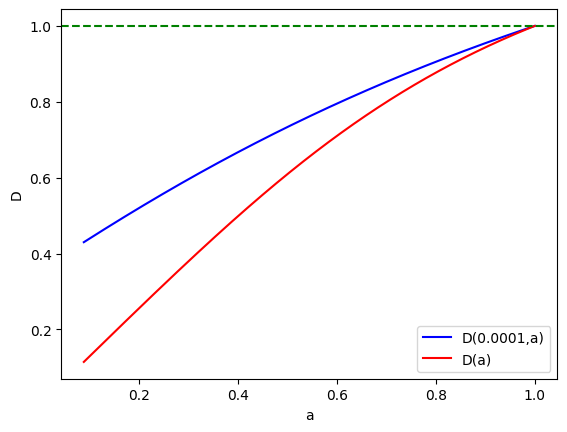

In [28]:
# plotto D(a) estratto da CLASS contro 2-D(k,a) estratto da me

plt.plot(aa, 2-dka[0,:], color='blue', label='D(' + str(kk[0]) + ',a)') # , linewidth='0.5')
# plt.plot(aa, 2-dka[n-1,:], color='pink', label='D(' + str(kk[n-1]) + ',a)' , linewidth='0.5')
plt.plot(aa, da, color='red', label='D(a)')
plt.axhline(y=1, color='green', linestyle='--')

plt.xlabel('a')
plt.ylabel('D')

plt.legend()
plt.show()

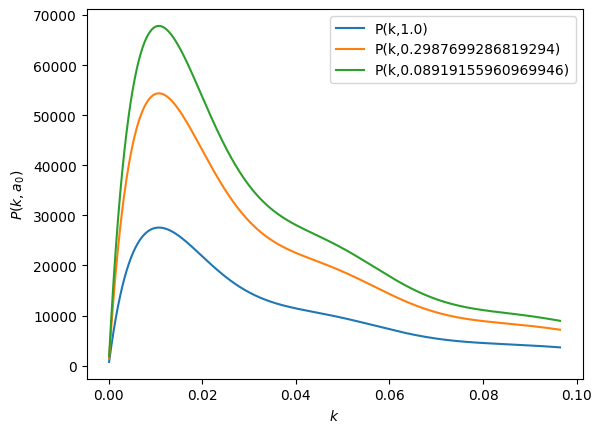

In [43]:
# secondo me P(k,1) cresce più velocemente di P(k,a), provo a plottarli con variabile k

pka = np.load('P(k,a)_m-neu=0.06.npy')
dim = 2000

plt.plot(kk[:dim], pka[:dim,-1], label='P(k,' + str(aa[-1]) + ')')
plt.plot(kk[:dim], pka[:dim,n//2], label='P(k,' + str(aa[n//2]) + ')')
plt.plot(kk[:dim], pka[:dim,0], label='P(k,' + str(aa[0]) + ')')

plt.xlabel('$k$')
plt.ylabel('$P(k,a_0)$')

plt.legend()
plt.show()